<h1>Environment</h1>

In [1]:
import astropy
print(astropy.__version__)


1.0.2


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Data input</h1>

Begin by importing the help functions in the 'proto' package:

In [3]:
import fit_functions

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be ignored by fit: simple 2-column ASCII file

In [1]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"

Read spectrum and regions files. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Mask is a float numpy array with 1's for good data points and 0's for ignored data points.

In [5]:
spectrum, mask = fit_functions.read_file(datafile, regions=regionsfile)

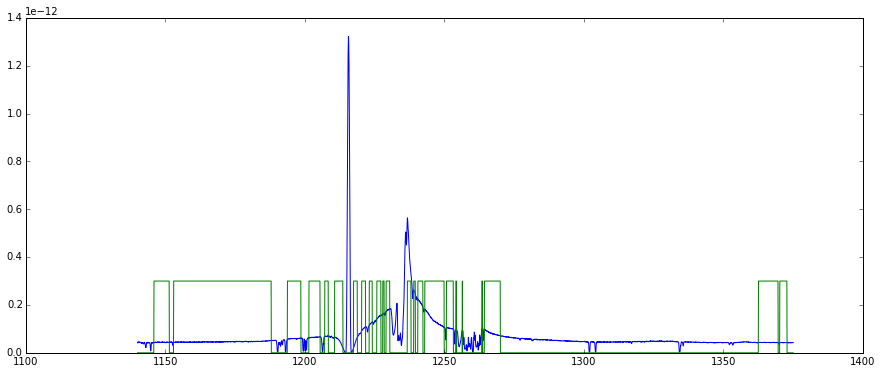

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, mask*3.E-13, 'g')

<h1>Initial model input</h1>

The model is imported directly:

In [2]:
import sfn5548_lyalpha_all_no_extinction as models

Model is a list of functions defined in the fit_functions modue. These in turn depend (override) functions in the astropy.modeling.models package. 

This overriding is necessary because the spectral components in specfit do not conform with the standards defined in astropy.modeling.models. For example, a Gaussian in specfit is defined by an amplitude, a central wavelength, a FWHM in km/s, and a skweness parameter. In astropy.modeling.models a Gaussian is defined by an amplitude, a central wavelength, and a width in units consistent with the units of the central wavelength. These incompatibilities are handled by the sub-classes defined in the fit_functions module. 

In [8]:
print(model)

[<powerlaw(amplitude=6.5862e-14, x_0=1000.0, alpha=0.4819233, name='powerlaw1')>, <gaussian(norm=2e-14, mean=1195.006, fwhm=861.4926, skew=1.0, name='gaussian2')>, <gaussian(norm=1.438015e-14, mean=1226.392, fwhm=861.4926, skew=1.0, name='gaussian3')>, <gaussian(norm=2.02e-13, mean=1236.729, fwhm=255.4998, skew=1.0, name='gaussian4')>, <gaussian(norm=5.474183e-13, mean=1235.996, fwhm=861.4926, skew=1.0, name='gaussian5')>, <gaussian(norm=3.948799e-12, mean=1235.138, fwhm=3040.59, skew=1.0, name='gaussian6')>, <gaussian(norm=2.156964e-12, mean=1231.589, fwhm=8133.099, skew=1.0, name='gaussian7')>, <gaussian(norm=5.36853e-13, mean=1237.643, fwhm=18183.71, skew=1.0, name='gaussian8')>, <gaussian(norm=1.217935e-14, mean=1259.753, fwhm=255.4998, skew=1.0, name='gaussian9')>, <gaussian(norm=1.217935e-14, mean=1263.803, fwhm=255.4998, skew=1.0, name='gaussian10')>, <gaussian(norm=6.219548e-15, mean=1259.533, fwhm=861.4926, skew=1.0, name='gaussian11')>, <gaussian(norm=6.219548e-15, mean=1263.

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

Now, to fit the multiple components in the model simultaneously, we have to build a compound model. An astropy compound model is just a combination of all the functions in the model, using as combination operators such things as additin, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

We build our component model by calling a function in the fit_functions module that will just add together all the functions in the input list:

In [9]:
compound_model = fit_functions.compoundModel(model)

In [10]:
print(compound_model)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0 x_0_0   alpha_0  norm_1 ... mean_20  fwhm_20   skew_20 
    ----------- ------ --------- ------ ... -------- -------- ---------
     6.5862e-14 1000.0 0.4819233  2e-14 ... 1262.044 3683.102 0.1849483


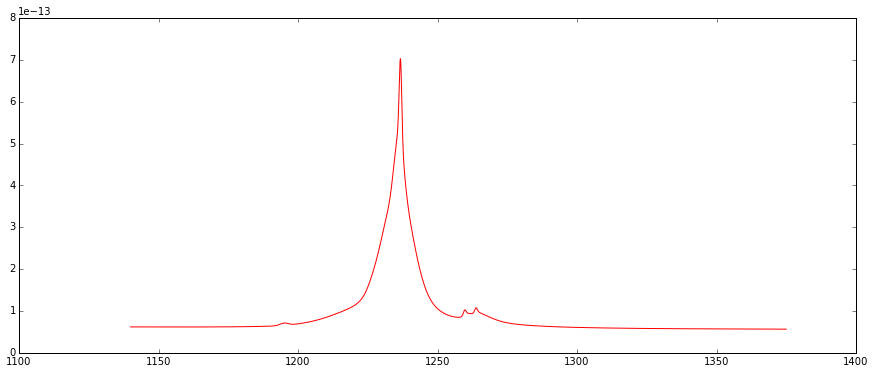

In [11]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')




The actual fitting then is a very simple operation. 

First, we instantiate a fitter engine:

In [12]:
import astropy.modeling.fitting as fitting

In [13]:
fitter = fitting.LevMarLSQFitter()

In this example, we have access to the errors for the data points, so we can use their inverse as weights for the fit:

In [14]:
import numpy as np
w = mask.copy()
w /= spectrum.e.data
max_w = np.max(w)
w /= max_w

And rhe fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed. Let's do some timing as well:

In [15]:
import time
start_time = time.time()

fit_result = fitter(compound_model, spectrum.x.data, spectrum.y.data, weights=w, acc=1.E-8, maxiter=1000)

end_time = time.time()

In [16]:
print(fitter.fit_info['message'])

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [17]:
print(fit_result)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
       amplitude_0    x_0_0      alpha_0     ...  mean_20   fwhm_20   skew_20 
    ----------------- ------ --------------- ... ---------- -------- ---------
    3.91142191496e-14 1000.0 -0.343893284607 ... 1262.04447 3683.102 0.1849483


Lets print some derived results:

In [18]:
fix = np.asarray(fit_result.fixed.values())
n_free_par = sum(np.where(fix, 0, 1))
chisq_in = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, compound_model, n_free_par)
chisq_out = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, fit_result, n_free_par)
print("chisq from input model:  %f" % chisq_in)
print("chisq from output model: %f" % chisq_out)
print("Total data points: %d" % len(spectrum.x.data))
print("Data points in wavelength ranges: %d" % np.sum(mask))
print("Number of free parameters: %d" % n_free_par)
print("Number of iterations: %d" % fitter.fit_info['nfev'])
print ("Fit engine took %d elapsed seconds." % (end_time - start_time))


chisq from input model:  26.335699
chisq from output model: 9.267772
Total data points: 6058
Data points in wavelength ranges: 2318
Number of free parameters: 40
Number of iterations: 45
Fit engine took 1 elapsed seconds.


<h1>Plots</h1>

<h3>Input and output compound models</h3>

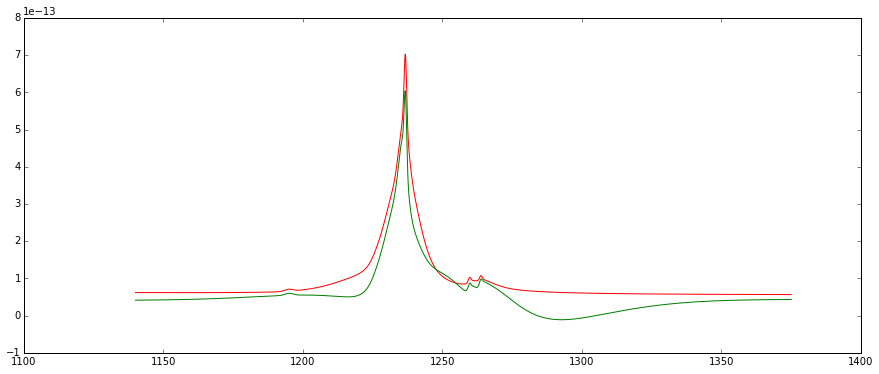

In [19]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')
fitted_spectrum = fit_result(spectrum.x.data)
plt.plot(spectrum.x.data, fitted_spectrum, 'g')

<h3>Input compound model overploted on spectrum</h3>

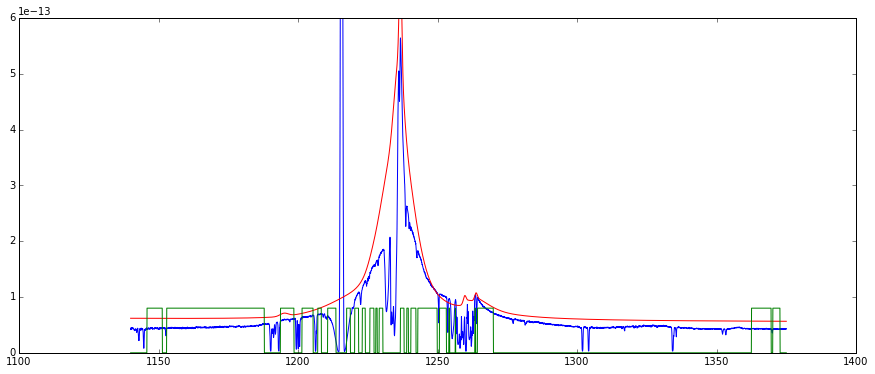

In [20]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

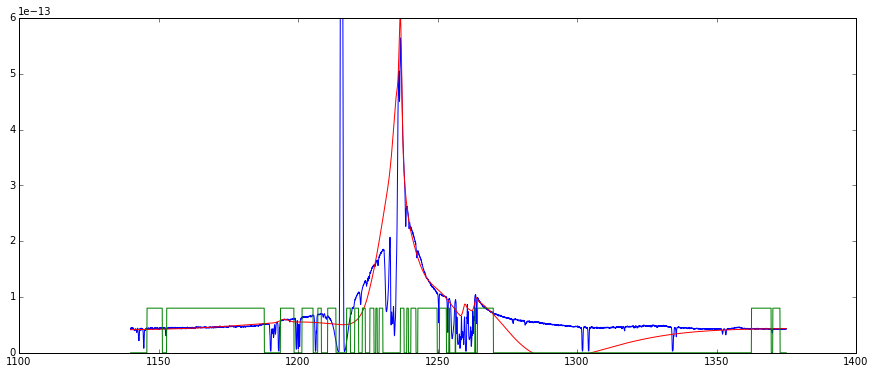

In [21]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, fitted_spectrum, 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [22]:
residuals = spectrum.y.data - fitted_spectrum
original_residuals = spectrum.y.data - compound_model(spectrum.x.data)

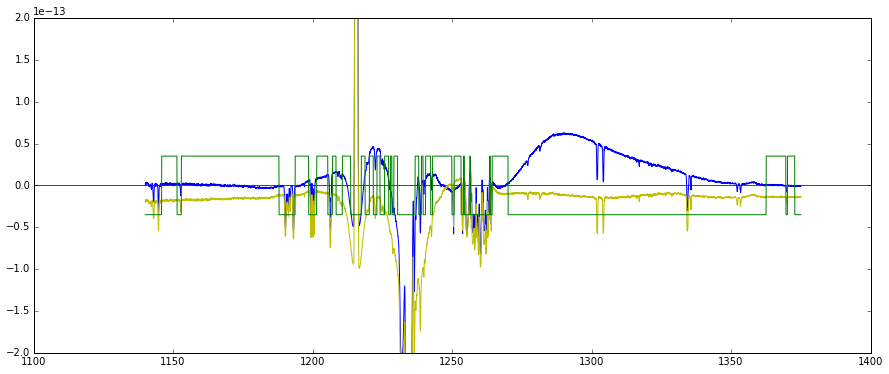

In [23]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

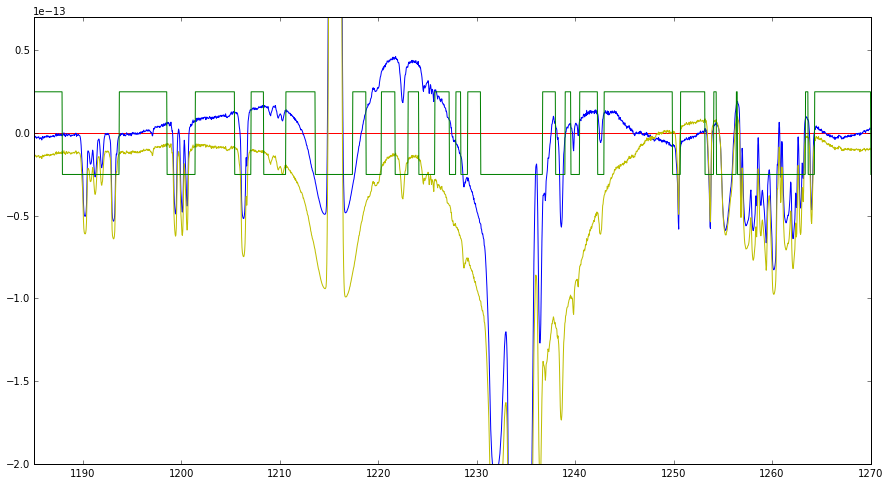

In [24]:
plt.gcf().set_size_inches(15.,8.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*5.E-14, 'g')